In [1]:
!pip install gymnasium opencv-python matplotlib numpy

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import cv2

class QLearningAgent:
   def __init__(self, n_bins=10, learning_rate=0.1, discount_factor=0.95,
                epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
       self.n_bins = n_bins
       self.lr = learning_rate
       self.gamma = discount_factor
       self.epsilon = epsilon
       self.epsilon_decay = epsilon_decay
       self.epsilon_min = epsilon_min

       self.q_table = defaultdict(lambda: np.zeros(2))  # 2 ações no CartPole

       # Limites para discretização do CartPole
       self.obs_high = np.array([2.4, 2.0, 0.2, 2.0])
       self.obs_low = np.array([-2.4, -2.0, -0.2, -2.0])

   def discretize_state(self, state):
       ratios = (state - self.obs_low) / (self.obs_high - self.obs_low)
       ratios = np.clip(ratios, 0, 1)
       discrete_state = (ratios * (self.n_bins - 1)).astype(int)
       return tuple(discrete_state)

   def choose_action(self, state):
       if random.random() < self.epsilon:
           return random.randint(0, 1)
       else:
           discrete_state = self.discretize_state(state)
           return np.argmax(self.q_table[discrete_state])

   def update_q_table(self, state, action, reward, next_state, done):
       discrete_state = self.discretize_state(state)
       discrete_next_state = self.discretize_state(next_state)

       current_q = self.q_table[discrete_state][action]

       if done:
           target = reward
       else:
           target = reward + self.gamma * np.max(self.q_table[discrete_next_state])

       self.q_table[discrete_state][action] += self.lr * (target - current_q)

   def decay_epsilon(self):
       self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def train_agent(episodes=2000):
   env = gym.make('CartPole-v1')
   agent = QLearningAgent()
   scores = []

   for episode in range(episodes):
       state, _ = env.reset()
       total_reward = 0
       done = False

       while not done:
           action = agent.choose_action(state)
           next_state, reward, terminated, truncated, _ = env.step(action)
           done = terminated or truncated

           # Penalidade por falhar
           if done and total_reward < 499:
               reward = -100

           agent.update_q_table(state, action, reward, next_state, done)
           state = next_state
           total_reward += reward

       agent.decay_epsilon()
       scores.append(total_reward)

       if episode % 200 == 0:
           avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)
           print(f"Episódio {episode}, Score médio: {avg_score:.1f}, Epsilon: {agent.epsilon:.3f}")

   env.close()
   return agent, scores

def create_video(agent, video_path="cartpole_final.mp4", episodes=5):
   env_video = gym.make('CartPole-v1', render_mode='rgb_array')

   fourcc = cv2.VideoWriter_fourcc(*'mp4v')
   fps = 30
   frame_size = (600, 400)
   video_writer = cv2.VideoWriter(video_path, fourcc, fps, frame_size)

   agent.epsilon = 0  # Sem exploração

   try:
       for episode in range(episodes):
           state, _ = env_video.reset()
           total_reward = 0
           steps = 0
           done = False

           while not done:
               action = agent.choose_action(state)
               state, reward, terminated, truncated, _ = env_video.step(action)
               done = terminated or truncated
               total_reward += reward
               steps += 1

               frame = env_video.render()
               frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

               # Texto no vídeo
               cv2.putText(frame_bgr, f'Ep: {episode+1}/{episodes}', (10, 30),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
               cv2.putText(frame_bgr, f'Steps: {steps}', (10, 60),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
               cv2.putText(frame_bgr, f'Reward: {total_reward}', (10, 90),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

               video_writer.write(frame_bgr)

           print(f"Episódio {episode + 1}: {steps} passos, Reward: {total_reward}")

           # Transição entre episódios
           if episode < episodes - 1:
               transition_frame = frame_bgr.copy()
               cv2.putText(transition_frame, f'Episode {episode+1} Complete', (120, 200),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)

               for _ in range(45):  # 1.5 segundos
                   video_writer.write(transition_frame)

   finally:
       video_writer.release()
       env_video.close()
       print(f"Vídeo salvo: {video_path}")



Iniciando treinamento...
Episódio 0, Score médio: -50.0, Epsilon: 0.995
Episódio 200, Score médio: -45.4, Epsilon: 0.365
Episódio 400, Score médio: 13.6, Epsilon: 0.134
Episódio 600, Score médio: 55.1, Epsilon: 0.049
Episódio 800, Score médio: 51.1, Epsilon: 0.018
Episódio 1000, Score médio: 54.3, Epsilon: 0.010
Episódio 1200, Score médio: 49.2, Epsilon: 0.010
Episódio 1400, Score médio: 49.7, Epsilon: 0.010
Episódio 1600, Score médio: 61.3, Epsilon: 0.010
Episódio 1800, Score médio: 57.2, Epsilon: 0.010


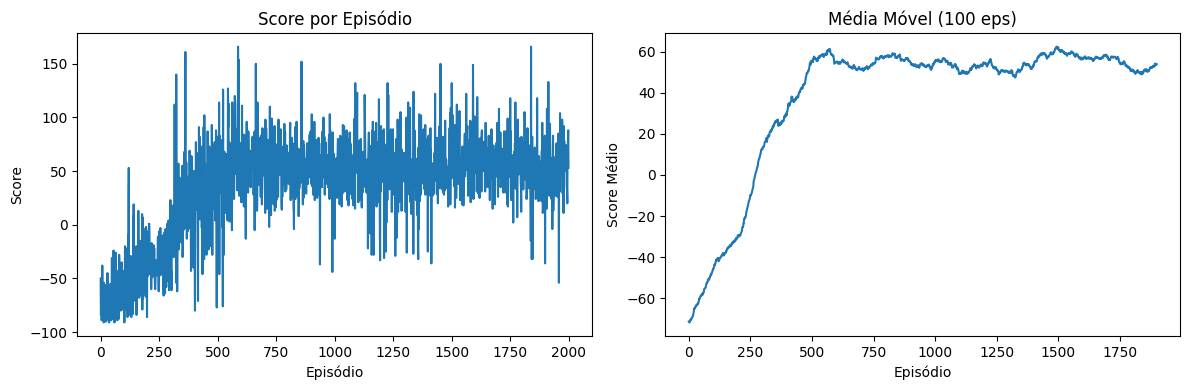

Gerando vídeo final...
Episódio 1: 174 passos, Reward: 174.0
Episódio 2: 118 passos, Reward: 118.0
Episódio 3: 149 passos, Reward: 149.0
Episódio 4: 183 passos, Reward: 183.0
Episódio 5: 173 passos, Reward: 173.0
Vídeo salvo: cartpole_final.mp4
Concluído!


In [3]:
if __name__ == "__main__":
   print("Iniciando treinamento...")
   trained_agent, training_scores = train_agent(episodes=2000)

   # Plot dos resultados
   plt.figure(figsize=(12, 4))

   plt.subplot(1, 2, 1)
   plt.plot(training_scores)
   plt.title('Score por Episódio')
   plt.xlabel('Episódio')
   plt.ylabel('Score')

   plt.subplot(1, 2, 2)
   window = 100
   if len(training_scores) >= window:
       moving_avg = [np.mean(training_scores[i:i+window]) for i in range(len(training_scores)-window)]
       plt.plot(moving_avg)
       plt.title(f'Média Móvel ({window} eps)')
       plt.xlabel('Episódio')
       plt.ylabel('Score Médio')

   plt.tight_layout()
   plt.show()

   print("Gerando vídeo final...")
   create_video(trained_agent, "cartpole_final.mp4", episodes=5)
   print("Concluído!")

In [4]:
create_video(trained_agent, "cartpole_final_20eps.mp4", episodes=20)
print("Concluído!")

Episódio 1: 183 passos, Reward: 183.0
Episódio 2: 147 passos, Reward: 147.0
Episódio 3: 174 passos, Reward: 174.0
Episódio 4: 126 passos, Reward: 126.0
Episódio 5: 131 passos, Reward: 131.0
Episódio 6: 195 passos, Reward: 195.0
Episódio 7: 191 passos, Reward: 191.0
Episódio 8: 136 passos, Reward: 136.0
Episódio 9: 159 passos, Reward: 159.0
Episódio 10: 173 passos, Reward: 173.0
Episódio 11: 160 passos, Reward: 160.0
Episódio 12: 154 passos, Reward: 154.0
Episódio 13: 158 passos, Reward: 158.0
Episódio 14: 160 passos, Reward: 160.0
Episódio 15: 181 passos, Reward: 181.0
Episódio 16: 178 passos, Reward: 178.0
Episódio 17: 185 passos, Reward: 185.0
Episódio 18: 158 passos, Reward: 158.0
Episódio 19: 198 passos, Reward: 198.0
Episódio 20: 135 passos, Reward: 135.0
Vídeo salvo: cartpole_final_20eps.mp4
Concluído!
